In [1]:
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.utils.tensorboard as tensorboard
import tqdm

### MNIST Data 

In [2]:
BATCH_SIZE = 64
NUM_WORKERS = 4

In [3]:
data_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(0.5,), std=(0.5,))
])

In [4]:
data = torchvision.datasets.MNIST(root="./data", train=True, transform=data_transform, download=True)
data_loader = torch.utils.data.DataLoader(dataset=data, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)

In [5]:
num_batches = len(data_loader)

#### Visualize MNIST Digits

In [6]:
def show(grid):
    plt.figure(figsize=(24, 12))
    plt.imshow(grid, cmap="gray")
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


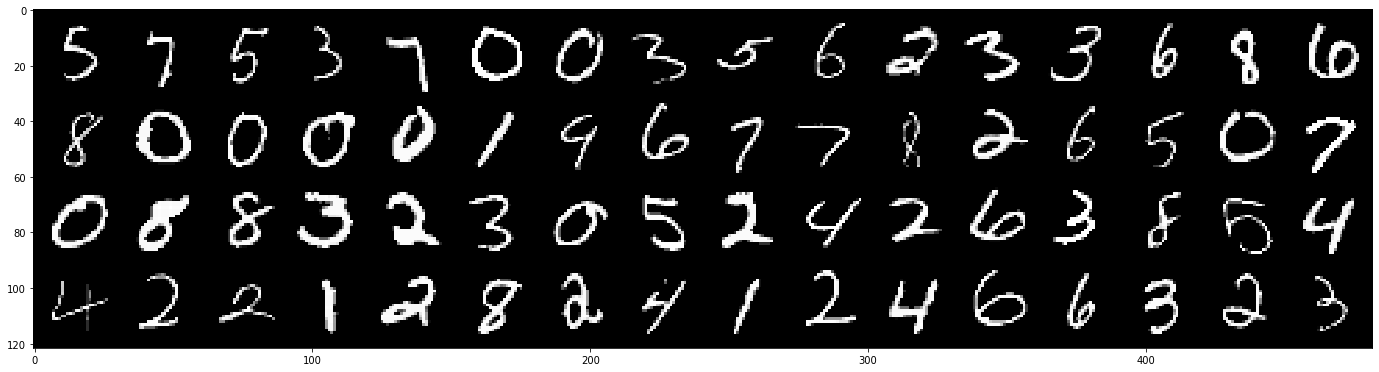

In [7]:
x, y = next(iter(data_loader))
grid = torchvision.utils.make_grid(x, nrow=16)
show(grid.permute(1, 2, 0))

In [8]:
print(x.shape, y.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64])


### Model

#### 1. Discriminator Model

In [9]:
class Discriminator(torch.nn.Module):
    
    def __init__(self, in_features=784, hidden_features=256, out_features=1):
        super(Discriminator, self).__init__() 
        
        self.out = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=hidden_features),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(in_features=hidden_features, out_features=hidden_features),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(in_features=hidden_features, out_features=out_features),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.out(x)
        return out

In [10]:
class Generator(torch.nn.Module):

    def __init__(self, laten_dim=100, hidden_features=256, out_features=784):
        
        super(Generator, self).__init__()
        
        # noise_dim is in_features 
        self.out = nn.Sequential(
            nn.Linear(in_features=laten_dim, out_features=hidden_features),
            nn.ReLU(),
            nn.Linear(in_features=hidden_features, out_features=hidden_features),
            nn.ReLU(),
            nn.Linear(in_features=hidden_features, out_features=out_features),
            nn.Tanh()
        )
        
    def forward(self, x):
        out = self.out(x)
        return out


### Training

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
writer = tensorboard.SummaryWriter()

In [20]:
lr = 0.0003
epochs = 100
latent_dim = 100
fixed_noise = torch.randn((BATCH_SIZE, latent_dim), device=device)

In [21]:
## Create models
gen = Generator().to(device)
disc = Discriminator().to(device)

In [22]:
criterion = nn.BCELoss().to(device)
d_optimizer = torch.optim.Adam(disc.parameters(), lr=lr)
g_optimizer = torch.optim.Adam(gen.parameters(), lr=lr)

Step:   0%|          | 0/938 [00:00<?, ?it/s]]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch 0 |  step  0 | d_loss 1.4515414237976074 | g_loss 0.6910539865493774


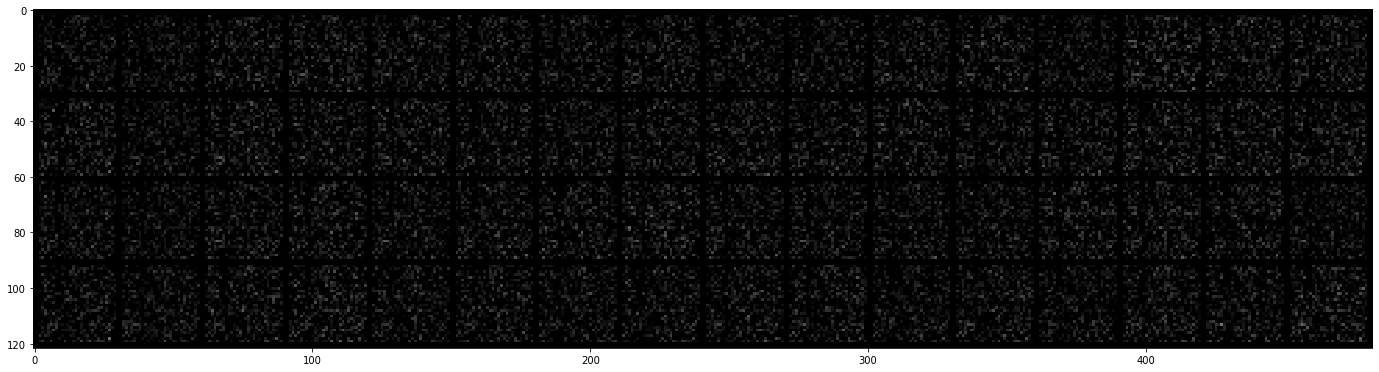

Step:  65%|██████▌   | 611/938 [00:05<00:02, 109.33it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch 10 |  step  10000 | d_loss 0.30046287178993225 | g_loss 4.290824890136719


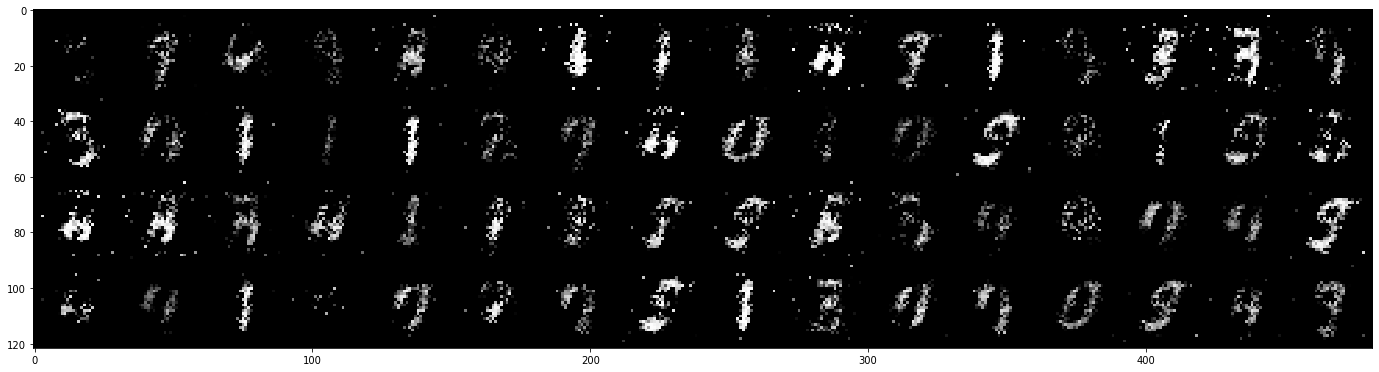

Step:  32%|███▏      | 298/938 [00:02<00:05, 112.78it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch 21 |  step  20000 | d_loss 0.6824005246162415 | g_loss 2.4338133335113525


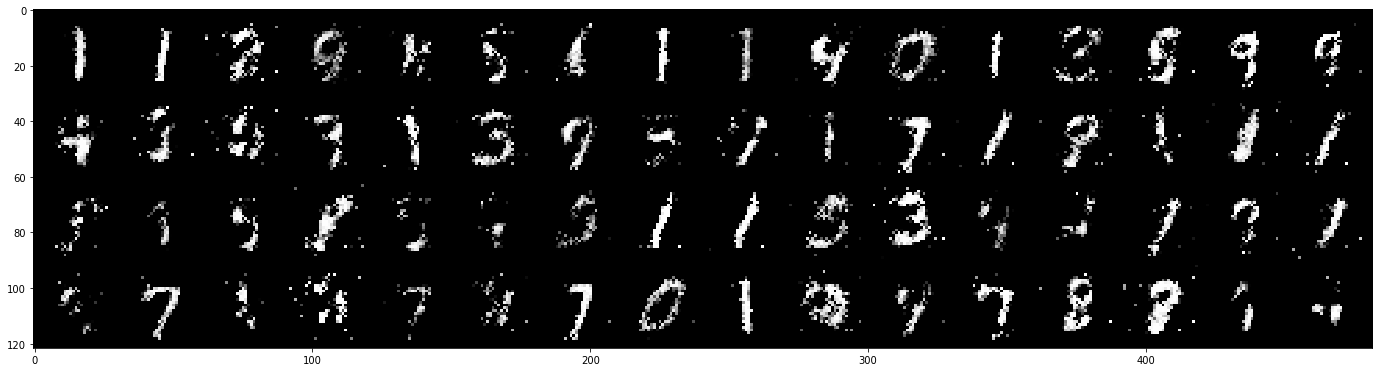

Step:  98%|█████████▊| 920/938 [00:08<00:00, 103.49it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch 31 |  step  30000 | d_loss 0.5630390644073486 | g_loss 2.063663959503174


Step: 100%|██████████| 938/938 [00:26<00:00, 105.69it/s]

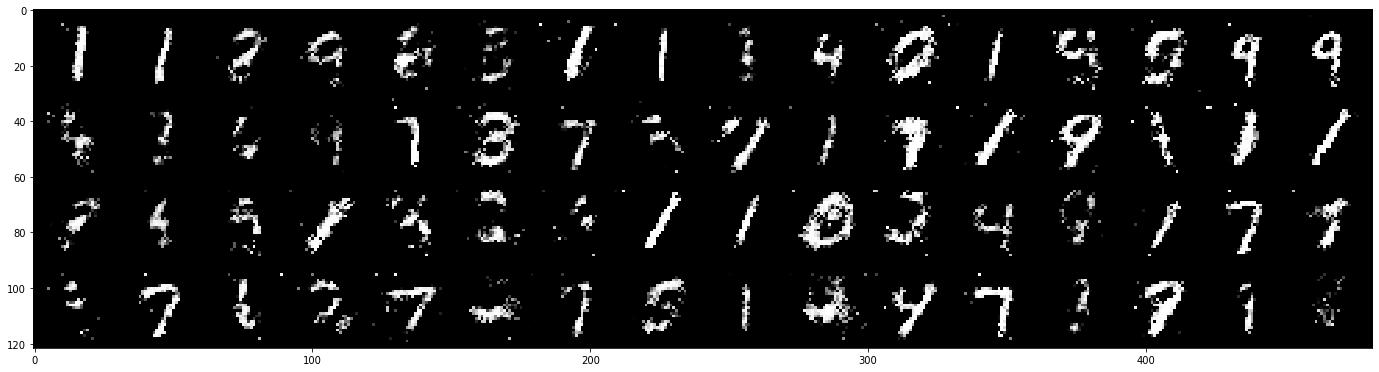

Step:  64%|██████▍   | 599/938 [00:05<00:03, 105.96it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch 42 |  step  40000 | d_loss 0.8069072961807251 | g_loss 2.134639024734497


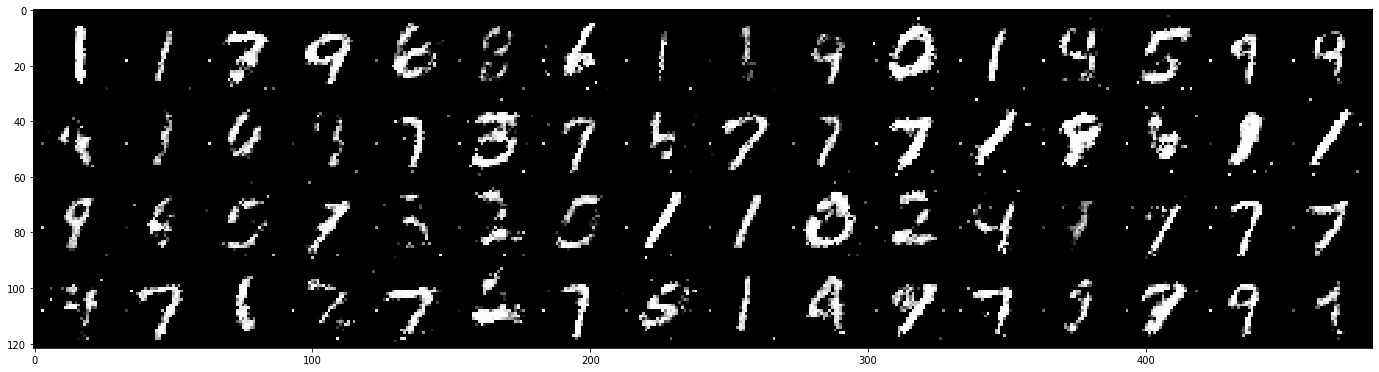

Step:  30%|███       | 282/938 [00:02<00:06, 105.63it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch 53 |  step  50000 | d_loss 0.7659952640533447 | g_loss 1.77567458152771


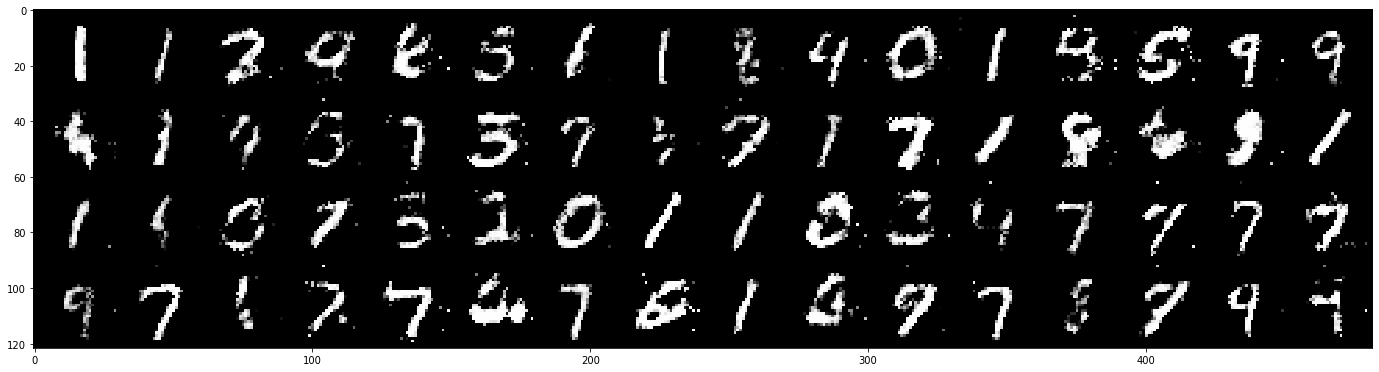

Step:  96%|█████████▋| 905/938 [00:08<00:00, 104.42it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch 63 |  step  60000 | d_loss 0.8558811545372009 | g_loss 1.7011613845825195


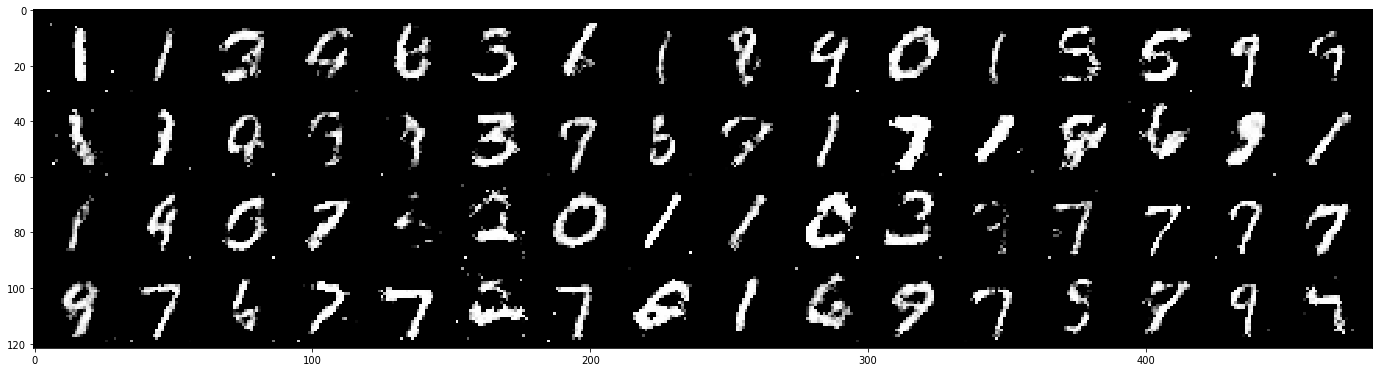

Step:  62%|██████▏   | 578/938 [00:05<00:03, 93.98it/s] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch 74 |  step  70000 | d_loss 1.2195820808410645 | g_loss 1.9401777982711792


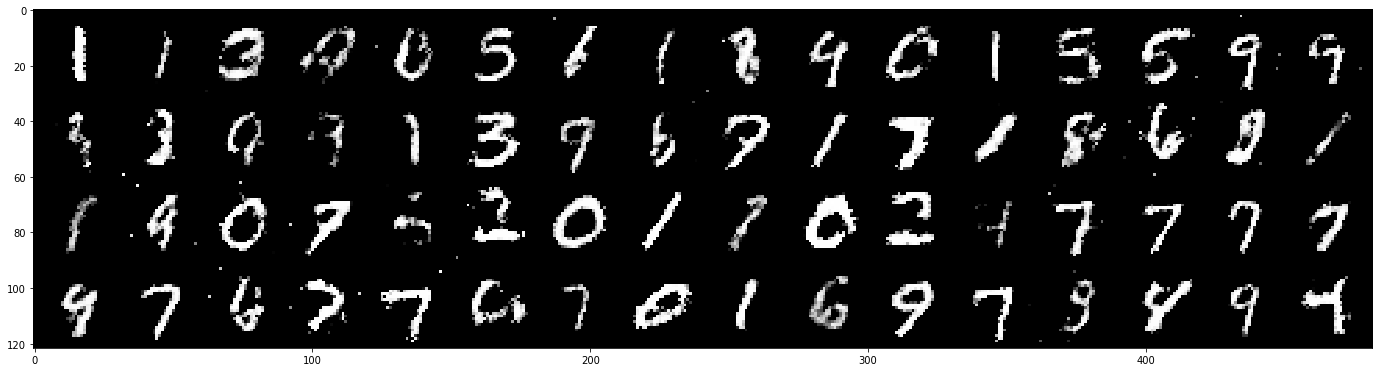

Step: 100%|██████████| 938/938 [00:22<00:00, 98.11it/s]

epoch 85 |  step  80000 | d_loss 0.998234748840332 | g_loss 1.908818006515503


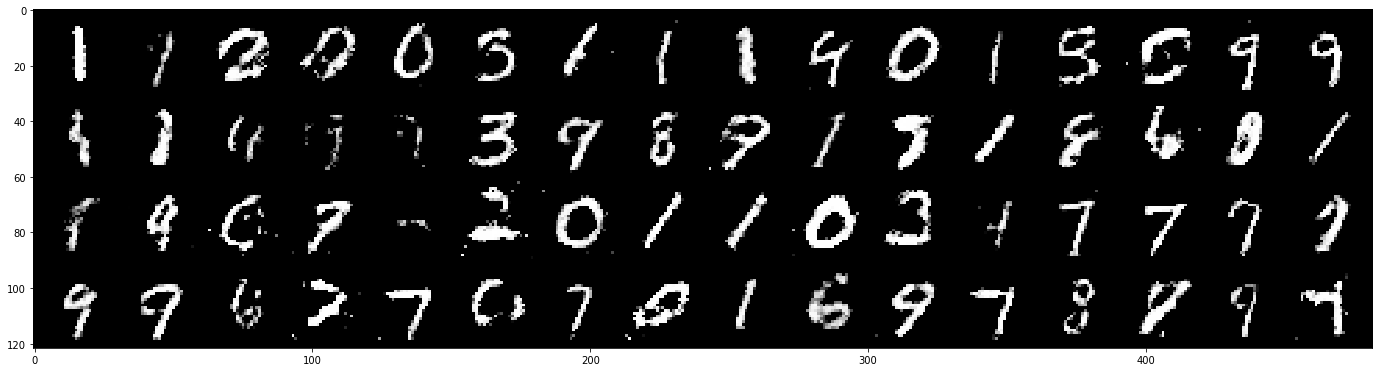

Step:  94%|█████████▍| 882/938 [00:09<00:00, 95.97it/s] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch 95 |  step  90000 | d_loss 0.7910981774330139 | g_loss 1.7134792804718018


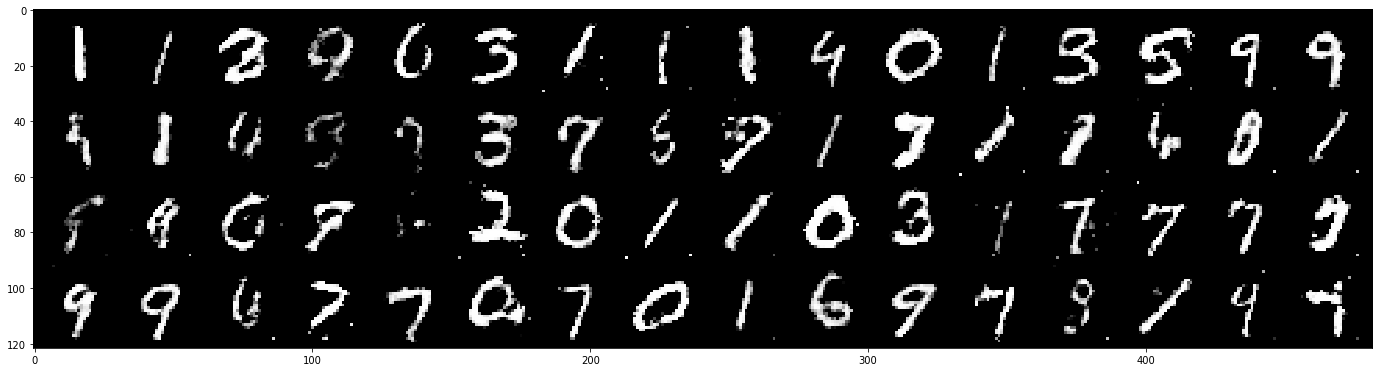

Step: 100%|██████████| 938/938 [00:25<00:00, 92.84it/s]]

In [23]:
steps = 0
epoch_progress = tqdm.tqdm(total=epochs, desc="Epoch", position=0)

for epoch in range(epochs):
    g_epoch_loss = []
    d_epoch_loss = []
    step_progress = tqdm.tqdm(total=num_batches, desc="Step", position=0)
    
    for i, (images, _) in enumerate(data_loader):
        
        batch, channel, h, w = images.size(0), images.size(1), images.size(2), images.size(3)
        
        images = images.view(-1, channel*h*w).to(device)
       
      
        real_labels = torch.ones((batch, 1), device=device)
        fake_labels = torch.zeros((batch, 1), device=device)
        
          
        """
            TRAIN DISCRIMINATOR 
        
        """
        
        d_optimizer.zero_grad()
        
        # Train on real data
        outputs = disc(images)
        d_loss_real = criterion(outputs, real_labels)
        
        # train on fake data
        # create fake data from gaussian noise
        noise = torch.randn((batch, latent_dim), device=device)
        fake_images = gen(noise)
        outputs = disc(fake_images)
        
        d_loss_fake = criterion(outputs, fake_labels)
    
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        # update the params
        d_optimizer.step()
        
        
        """
        -- TRAIN GENERATOR --
        """
        
        g_optimizer.zero_grad()
        
        noise = torch.randn((batch, latent_dim), device=device)
        labels = torch.ones((batch, 1), device=device)
        gen_images = gen(noise)
        outputs = disc(gen_images)
        g_loss = criterion(outputs, labels)
        
        g_loss.backward()
        g_optimizer.step()
        
        
        writer.add_scalar("step_wise_loss", d_loss.item(), steps)
        writer.add_scalar("step_wise_loss", g_loss.item(), steps)
        g_epoch_loss.append(g_loss.item())
        d_epoch_loss.append(d_loss.item())
        
        if steps%10000==0:
            print(f'epoch {epoch} |  step  {steps} | d_loss {d_loss.item()} | g_loss {g_loss.item()}')
            
            with torch.no_grad():
                samples = gen(fixed_noise)
            
            grid  = torchvision.utils.make_grid(samples.view(-1, 1, 28, 28).detach().cpu(), nrow=16)
            show(grid.permute(1, 2, 0))
            
    
        step_progress.update(1)
        steps += 1
        
    g_loss_avg = sum(g_epoch_loss)/len(g_epoch_loss)
    d_loss_avg = sum(d_epoch_loss)/len(d_epoch_loss)
    
    writer.add_scalar("epoch_wise_loss", g_loss_avg, epoch)
    writer.add_scalar("epoch_wise_loss", d_loss_avg, epoch)
    epoch_progress.update(1)